# Amazon Reviews Analysis with Sentiment Analysis

This notebook performs Named Entity Recognition (NER) and Sentiment Analysis on Amazon reviews to extract product names, brands, and analyze review sentiments.

## 1. Setup and Dependencies

In [1]:
# Install required packages if not already installed
!pip install spacy pandas matplotlib seaborn
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 1.5 MB/s eta 0:00:09
     --- ------------------------------------ 1.0/12.8 MB 1.6 MB/s eta 0:00:08
     ---- ----------------------------------- 1.3/12.8 MB 1.6 MB/s eta 0:00:08
     ---- ----------------------------------- 1.6/12.8 MB 1.6 MB/s eta 0:00:08
     ------ --------------------------------- 2.1/12.8 MB 1.6 MB/s eta 0:00:07
     ------- -------------------------------- 2.4/12.8 MB 1.6 MB/s eta 0:00:07
     -------- ------------------------------- 2.6/12.8 MB 1.5 MB/s eta 0:00:07
     -------- ------------------------------- 2.6/12.8 MB 1.5 MB/s eta 0:00:07
     --------- ------------------------------ 3.1/12.8 MB 1.5 MB/s eta 0:00:07
     ---------- ----------------------------- 3.4/12.8 MB 1.4 MB/s eta 0:

In [2]:
import pandas as pd
import spacy
from collections import Counter, defaultdict
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_theme()
sns.set_palette('husl')

## 2. Load and Prepare Data

In [3]:
# Load the spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
    print("SpaCy model loaded successfully")
except OSError:
    print("Error: SpaCy model not found. Please run the installation command above.")

# Load the dataset
try:
    df = pd.read_csv("amazon_reviews.csv")
    print(f"Dataset loaded successfully with {len(df)} reviews")
except FileNotFoundError:
    print("Error: amazon_reviews.csv not found. Please ensure the file is in the correct directory.")

# Display initial data info
print("\nInitial DataFrame Info:")
print(df.info())

# Data Cleaning Steps
print("\nPerforming data cleaning...")

# 1. Remove duplicate reviews
initial_len = len(df)
df = df.drop_duplicates(subset=['reviewText'], keep='first')
print(f"Removed {initial_len - len(df)} duplicate reviews")

# 2. Handle missing values
print("\nMissing values before cleaning:")
print(df.isnull().sum())

# Fill missing reviewer names with 'Anonymous'
df['reviewerName'] = df['reviewerName'].fillna('Anonymous')

# Remove rows with missing review text
df = df.dropna(subset=['reviewText'])
print(f"\nAfter removing missing reviews: {len(df)} reviews remaining")

# 3. Clean review text
def clean_review_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and extra spaces
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = text.strip()
    
    return text

# Apply text cleaning
df['reviewText'] = df['reviewText'].apply(clean_review_text)

# 4. Remove very short reviews (less than 10 characters)
df = df[df['reviewText'].str.len() >= 10]
print(f"After removing very short reviews: {len(df)} reviews remaining")

# 5. Convert reviewTime to datetime
df['reviewTime'] = pd.to_datetime(df['reviewTime'], format='%m %d, %Y', errors='coerce')

# 6. Add review length column
df['review_length'] = df['reviewText'].str.len()

# 7. Basic statistics about the cleaned data
print("\nCleaned Data Statistics:")
print(f"Total number of reviews: {len(df)}")
print(f"Number of unique reviewers: {df['reviewerName'].nunique()}")
print(f"Date range: {df['reviewTime'].min()} to {df['reviewTime'].max()}")
print(f"Average review length: {df['review_length'].mean():.2f} characters")
print(f"Median review length: {df['review_length'].median():.2f} characters")

# Display sample of cleaned data
print("\nSample of cleaned reviews:")
display(df[['reviewerName', 'reviewText', 'review_length']].head())

# Save cleaned data
df.to_csv('cleaned_amazon_reviews.csv', index=False)
print("\nCleaned data saved to 'cleaned_amazon_reviews.csv'")

SpaCy model loaded successfully
Dataset loaded successfully with 4915 reviews

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB
None

Perfor

,reviewerName,reviewText,review_length
1,0mie,purchased this for my device it worked as adve...,154
2,1K3,it works as expected i should have sprung for ...,162
3,1m2,this think has worked out great had a diff bra...,319
4,2&amp;1/2Men,bought it with retail packaging arrived legit ...,279
5,2Cents!,it s mini storage it doesn t do anything else ...,270



Cleaned data saved to 'cleaned_amazon_reviews.csv'


## 3. Entity Extraction and Analysis

In [4]:
# Initialize counters for different entity types
entities = {
    'PRODUCT': [],
    'ORG': []
}

# Initialize relationship tracking
product_brand_relationships = defaultdict(list)

def clean_text(text):
    # Remove special characters and extra spaces
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Process each review
for idx, row in df.iterrows():
    review = nlp(row['reviewText'])
    review_entities = []
    
    # Collect all entities in the review
    for ent in review.ents:
        if ent.label_ in entities:
            cleaned_text = clean_text(ent.text)
            if cleaned_text and len(cleaned_text) > 1:
                entities[ent.label_].append(cleaned_text)
                review_entities.append((ent.label_, cleaned_text))
    
    # Track relationships between products and brands
    products = [ent[1] for ent in review_entities if ent[0] == 'PRODUCT']
    brands = [ent[1] for ent in review_entities if ent[0] == 'ORG']
    
    for product in products:
        for brand in brands:
            product_brand_relationships[product].append(brand)

# Get the most common entities for each type
common_entities = {}
for entity_type, entity_list in entities.items():
    common_entities[entity_type] = Counter(entity_list).most_common(10)

## 4. Visualize Entity Recognition Results

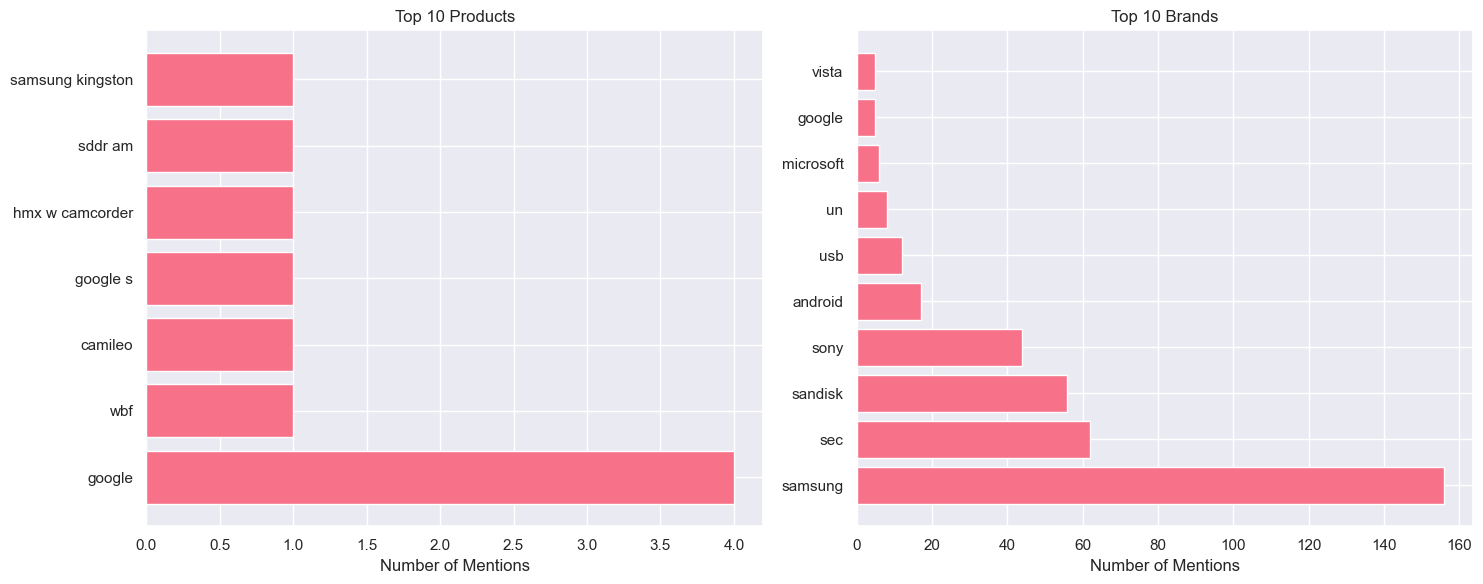

In [5]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot top products
products = [item[0] for item in common_entities['PRODUCT']]
product_counts = [item[1] for item in common_entities['PRODUCT']]
ax1.barh(products, product_counts)
ax1.set_title('Top 10 Products')
ax1.set_xlabel('Number of Mentions')

# Plot top brands
brands = [item[0] for item in common_entities['ORG']]
brand_counts = [item[1] for item in common_entities['ORG']]
ax2.barh(brands, brand_counts)
ax2.set_title('Top 10 Brands')
ax2.set_xlabel('Number of Mentions')

plt.tight_layout()
plt.show()

## 5. Display Detailed Entity Analysis

In [6]:
# Create a DataFrame for products and their associated brands
product_data = []
for product, count in common_entities['PRODUCT']:
    associated_brands = Counter(product_brand_relationships[product]).most_common(3)
    brand_text = ', '.join([f"{brand} ({count})" for brand, count in associated_brands])
    product_data.append({
        'Product': product,
        'Mentions': count,
        'Associated Brands': brand_text
    })

product_df = pd.DataFrame(product_data)
print("\nTop Products and Their Brand Associations:")
display(product_df)

# Create a DataFrame for brands
brand_data = [{'Brand': brand, 'Mentions': count} for brand, count in common_entities['ORG']]
brand_df = pd.DataFrame(brand_data)
print("\nTop Brands:")
display(brand_df)


Top Products and Their Brand Associations:


,Product,Mentions,Associated Brands
0,google,4,"samsung (4), dropbox (1)"
1,wbf,1,
2,camileo,1,toshiba (1)
3,google s,1,"lg g pad (1), sony xperia z (1)"
4,hmx w camcorder,1,
5,sddr am,1,"sec (1), motorola (1)"
6,samsung kingston,1,



Top Brands:


,Brand,Mentions
0,samsung,156
1,sec,62
2,sandisk,56
3,sony,44
4,android,17
5,usb,12
6,un,8
7,microsoft,6
8,google,5
9,vista,5


## 6. Summary Statistics

In [7]:
print(f"Total products found: {len(entities['PRODUCT'])}")
print(f"Total brands found: {len(entities['ORG'])}")
print(f"\nAnalysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Total products found: 10
Total brands found: 517

Analysis completed at: 2025-06-16 03:31:52


## 7. Sentiment Analysis Setup

In [8]:
# Define sentiment dictionaries
POSITIVE_WORDS = {
    'good', 'great', 'excellent', 'amazing', 'wonderful', 'fantastic', 'perfect',
    'love', 'best', 'awesome', 'outstanding', 'brilliant', 'superb', 'terrific',
    'highly', 'recommend', 'satisfied', 'happy', 'pleased', 'impressed', 'quality',
    'worth', 'value', 'enjoy', 'enjoyed', 'enjoying', 'enjoys', 'enjoyable',
    'smooth', 'fast', 'quick', 'easy', 'convenient', 'comfortable', 'reliable',
    'durable', 'sturdy', 'solid', 'beautiful', 'attractive', 'stylish', 'modern',
    'innovative', 'creative', 'unique', 'special', 'premium', 'luxury', 'deluxe'
}

NEGATIVE_WORDS = {
    'bad', 'poor', 'terrible', 'awful', 'horrible', 'worst', 'waste', 'disappointed',
    'disappointing', 'disappointment', 'hate', 'hated', 'hates', 'hating', 'useless',
    'worthless', 'cheap', 'flimsy', 'broken', 'damaged', 'defective', 'faulty',
    'problem', 'problems', 'issue', 'issues', 'difficult', 'hard', 'complicated',
    'confusing', 'unclear', 'unreliable', 'unstable', 'slow', 'noisy', 'loud',
    'expensive', 'overpriced', 'costly', 'difficult', 'trouble', 'troublesome',
    'annoying', 'frustrated', 'frustrating', 'frustration', 'regret', 'regretted'
}

NEGATION_WORDS = {
    'not', 'no', 'never', 'none', 'neither', 'nor', 'nothing', 'nowhere',
    'hardly', 'barely', 'scarcely', "doesn't", "don't", "didn't", "isn't",
    "aren't", "wasn't", "weren't", "hasn't", "haven't", "hadn't", "won't",
    "wouldn't", "couldn't", "shouldn't", "can't", "cannot"
}

def analyze_sentiment(text):
    """
    Analyze the sentiment of a text using a rule-based approach.
    Returns a sentiment score between -1 (very negative) and 1 (very positive).
    """
    # Convert text to lowercase and split into words
    words = text.lower().split()
    
    # Initialize counters
    positive_count = 0
    negative_count = 0
    negation_active = False
    
    # Analyze each word
    for i, word in enumerate(words):
        # Check for negation
        if word in NEGATION_WORDS:
            negation_active = True
            continue
            
        # Check for positive words
        if word in POSITIVE_WORDS:
            if negation_active:
                negative_count += 1
            else:
                positive_count += 1
                
        # Check for negative words
        elif word in NEGATIVE_WORDS:
            if negation_active:
                positive_count += 1
            else:
                negative_count += 1
                
        # Reset negation after a few words
        if negation_active and i > 0 and words[i-1] in NEGATION_WORDS:
            negation_active = False
    
    # Calculate sentiment score
    total = positive_count + negative_count
    if total == 0:
        return 0
    
    sentiment_score = (positive_count - negative_count) / total
    return sentiment_score

def get_sentiment_label(score):
    """
    Convert a sentiment score to a label.
    """
    if score > 0.2:
        return 'Positive'
    elif score < -0.2:
        return 'Negative'
    else:
        return 'Neutral'


## 8. Reviewer-Level Sentiment Analysis


Sentiment Distribution:
sentiment_label
Positive    3052
Neutral     1340
Negative     510
Name: count, dtype: int64


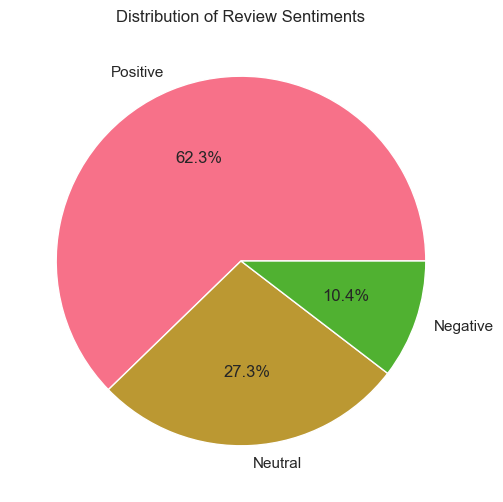


Example Reviews for Each Sentiment:

Positive Reviews:
Score: 1.00
Review: this is a great sd card it s very fast and works well i have been using it for my gopro with no complaints...
--------------------------------------------------------------------------------
Score: 1.00
Review: actually their is an extreme version but the price is about double and since i am not planning to shoot in   or k their was no need to pay more and get no improvement grabbed  of these one for my fath...
--------------------------------------------------------------------------------

Neutral Reviews:
Score: 0.00
Review: this is a piece of crap this is my rd card in  months this is ridiculous do not buy this crap...
--------------------------------------------------------------------------------
Score: 0.00
Review: it works just fine and i m thinking of getting a gb for my tablet later on i don t have too much more to say except buy...
---------------------------------------------------------------------

In [9]:
# Analyze sentiments for all reviews
df['sentiment_score'] = df['reviewText'].apply(analyze_sentiment)
df['sentiment_label'] = df['sentiment_score'].apply(get_sentiment_label)

# Display sentiment distribution
sentiment_counts = df['sentiment_label'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_counts)

# Create a pie chart of sentiment distribution
plt.figure(figsize=(10, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Review Sentiments')
plt.show()

# Display some example reviews for each sentiment
print("\nExample Reviews for Each Sentiment:")
for sentiment in ['Positive', 'Neutral', 'Negative']:
    print(f"\n{sentiment} Reviews:")
    examples = df[df['sentiment_label'] == sentiment].sample(2)
    for _, row in examples.iterrows():
        print(f"Score: {row['sentiment_score']:.2f}")
        print(f"Review: {row['reviewText'][:200]}...")
        print("-" * 80)



Top 10 Most Active Reviewers and Their Sentiments:


,Reviewer Name,Average Sentiment,Dominant Sentiment,Review Count
174,Amazon Customer,0.487052,Positive,121
965,David,0.526667,Positive,10
2508,Michael,0.074074,Negative,9
691,Chris,0.812500,Positive,8
1892,John,0.171429,Neutral,7
2563,Mike,0.571429,Positive,7
1848,Jim,0.250000,Positive,6
481,Brandon,0.333333,Positive,6
2415,Mark,0.305556,Positive,6
1195,Eric,-0.066667,Positive,6


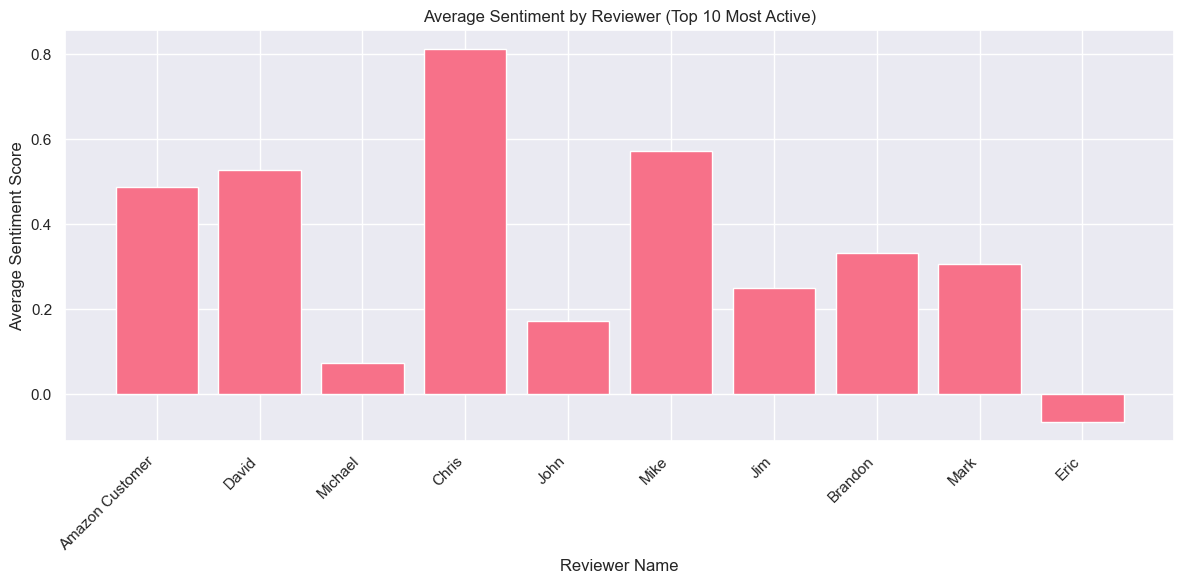

In [10]:
# Analyze sentiment by reviewer
reviewer_sentiments = df.groupby('reviewerName').agg({
    'sentiment_score': 'mean',
    'sentiment_label': lambda x: x.value_counts().index[0],
    'reviewText': 'count'
}).reset_index()

reviewer_sentiments.columns = ['Reviewer Name', 'Average Sentiment', 'Dominant Sentiment', 'Review Count']
reviewer_sentiments = reviewer_sentiments.sort_values('Review Count', ascending=False)

print("\nTop 10 Most Active Reviewers and Their Sentiments:")
display(reviewer_sentiments.head(10))

# Create a bar plot of average sentiment by reviewer
plt.figure(figsize=(12, 6))
top_reviewers = reviewer_sentiments.head(10)
plt.bar(top_reviewers['Reviewer Name'], top_reviewers['Average Sentiment'])
plt.xticks(rotation=45, ha='right')
plt.title('Average Sentiment by Reviewer (Top 10 Most Active)')
plt.xlabel('Reviewer Name')
plt.ylabel('Average Sentiment Score')
plt.tight_layout()
plt.show()